In [1]:
import numpy as np

import tenpy
from tenpy.models.hubbard import FermiHubbardChain
from tenpy.models.lattice import Square
from tenpy.models import CouplingMPOModel
from tenpy.networks.site import FermionSite, BosonSite, SpinHalfFermionSite, spin_half_species
from tenpy.networks.mps import MPS
from tenpy.networks.mpo import MPO
from tenpy.algorithms import dmrg, tebd, tdvp
from tenpy.algorithms.mps_common import DensityMatrixMixer, SubspaceExpansion
import tenpy.linalg.np_conserved as npc
import h5py
from timeit import default_timer as timer
from tqdm import tqdm
import matplotlib.pyplot as plt


/home1/wttai/TeNPy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [2]:
class FermiHubbardSquare(CouplingMPOModel):
    
    def init_sites(self, model_params):
        cons_N = model_params.get('cons_N', 'N', str)
        cons_Sz = model_params.get('cons_Sz', 'Sz', str)
        site = SpinHalfFermionSite(cons_N=cons_N, cons_Sz=cons_Sz)
        return site

    def init_lattice(self, model_params):
        site = self.init_sites(model_params)
        Lx = model_params.get('Lx', 4)
        Ly = model_params.get('Ly', 4)
        return Square(Lx=Lx, Ly=Ly, site=site)

    def init_terms(self, model_params):
        # read out parameters
        t = model_params.get("t", 1.) 
        Uv = model_params.get("U", 1.)
        m = model_params.get("m", 1)
        # add terms
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(Uv, u, 'NuNd')
            self.add_onsite(m, u, "Nu")
            self.add_onsite(-m, u, "Nd")
        for i1, i2, dx in self.lat.pairs["nearest_neighbors"]:
            self.add_coupling(t, i1, "Cdu", i2, "Cu", dx, plus_hc=True)
            self.add_coupling(-t, i1, "Cdd", i2, "Cd", dx, plus_hc=True)
            if np.array_equal(dx, [1,0]):
                self.add_coupling(1j * t, i1, "Cdu", i2, "Cd", dx, plus_hc=True)
                self.add_coupling(1j * t, i1, "Cdd", i2, "Cu", dx, plus_hc=True)
            if np.array_equal(dx, [0,1]):
                self.add_coupling(t, i1, "Cdu", i2, "Cd", dx, plus_hc=True)
                self.add_coupling(-t, i1, "Cdd", i2, "Cu", dx, plus_hc=True)        

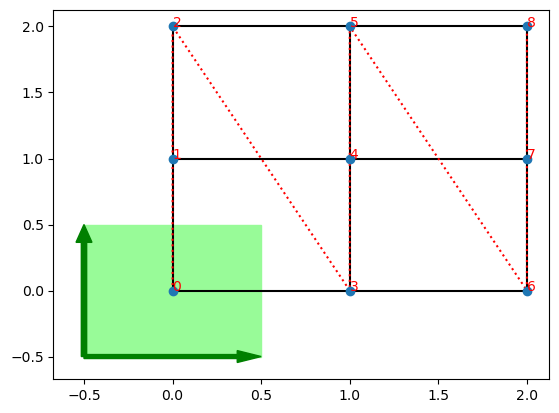

In [5]:
fig, ax = plt.subplots()
lat = Square(Lx=3, Ly=3, site= SpinHalfFermionSite)
lat.plot_coupling(ax)
lat.plot_order(ax, linestyle=':')
lat.plot_sites(ax)
lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))

In [9]:
L = 2
Lx = 2
Ly = 2
t = 1.0
U = 1.0
m = 1.0
# Create the Fermi-Hubbard Model
model_params = {
    't': t,                 # Nearest-neighbor hopping strength
    'U': U,                 # On-site Hubbard interaction
    'm': m,                 # Mass gap
    'Lx': Lx,
    'Ly': Ly,
    'cons_Sz': None,
    'cons_N': 'N',
}

model = FermiHubbardSquare(model_params)
H_mpo = model.calc_H_MPO()
print(f'MPO bond dimensions: {H_mpo.chi}')


INFO:tenpy.tools.params:FermiHubbardSquare: reading 'cons_N'='N'
INFO:tenpy.tools.params:FermiHubbardSquare: reading 'cons_Sz'=None
INFO:tenpy.tools.params:FermiHubbardSquare: reading 'Lx'=2
INFO:tenpy.tools.params:FermiHubbardSquare: reading 'Ly'=2
INFO:tenpy.tools.params:FermiHubbardSquare: reading 't'=1.0
INFO:tenpy.tools.params:FermiHubbardSquare: reading 'U'=1.0
INFO:tenpy.tools.params:FermiHubbardSquare: reading 'm'=1.0


MPO bond dimensions: [2, 6, 10, 10, 2]


In [5]:
# Exact Diagonalization—for sanity check
if Lx * Ly < 8:
    test = tenpy.algorithms.exact_diag.ExactDiag(model)
    test.build_full_H_from_mpo()
    test.full_diagonalization()
    print(test.groundstate())

(-7.020323850733519, <npc.Array shape=(256,) labels=['ps']>)


In [6]:
import logging
logging.basicConfig(level=logging.INFO)

In [7]:
dmrg_params = {
    "mixer": DensityMatrixMixer,
    "mixer_params": {
        "amplitude": 0.3,
        "decay": 2,
        "disable_after": 20
    },
    "trunc_params": {
        "chi_max": 100, #bond dimension
        "svd_min": 1*10**-10
    },
    "max_E_err": 0.0001, #energy convergence step threshold
    "max_S_err": 0.0001, #entropy convergence step threshold
    "max_sweeps": 1000  #may or may not be enough to converge
}

product_state = [ 'down' for n in range(Lx * Ly) ]
psi = MPS.from_product_state(model.lat.mps_sites(), product_state, bc=model.lat.bc_MPS)

engine = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)

E0, psi = engine.run()
print(f'Ground state energy: {E0}')

INFO:tenpy.tools.params:TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:TwoSiteDMRGEngine: subconfig 'mixer_params'=Config(<3 options>, 'mixer_params')
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=<class 'tenpy.algorithms.mps_common.DensityMatrixMixer'>
INFO:tenpy.algorithms.mps_common:activate DensityMatrixMixer with initial amplitude 0.3
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_sweeps'=1000
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-10
INFO:tenpy.tools.params:lanczos_params: setting 'P_tol'=5.0000000000000005e-22
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 1
energy=-6.9617218422268987, max S=1.2462086558271932, age=4, norm_err=2.8e-01
Current memory usage 165.0MB, wall time: 0.1s
Delta E = nan, Delta S = 1.1582e+00 (per sweep)
max trunc_err = 7.6953e-21, max E_t

Ground state energy: -6.961721842226901


In [16]:
import h5py
from tenpy.tools import hdf5_io
data = {"psi": psi,  # e.g. an MPS
        "E0": E0,  # ground state energy
        "model": model,
        "sweepstats": engine.sweep_stats,
        "parameters": {"L": Lx * Ly, "t": t, "U": U, "m": m}
}


outputFilename=f"machine_learning/dmrg_qwz/data/dmrg_log_L={L}_t={t}_m={m}_U={U}"

with h5py.File(outputFilename, 'w') as f:
    hdf5_io.save_to_hdf5(f, data)

In [26]:
t = 1.0
m = 5.0
U = 1.0
outputFilename=f"machine_learning/dmrg_qwz/data/dmrg_log_L={4}_t={t}_m={m}_U={U}"
with h5py.File(outputFilename, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)

In [18]:
data

{'E0': -6.961721842226901,
 'model': <__main__.FermiHubbardSquare at 0x2b16570491f0>,
 'parameters': {'L': 4, 'U': 1.0, 'm': 1.0, 't': 1.0},
 'psi': <tenpy.networks.mps.MPS at 0x2b1657048bf0>,
 'sweepstats': {'Delta_E': [nan,
   -3.552713678800501e-15,
   -2.6645352591003757e-15,
   8.881784197001252e-16,
   6.217248937900877e-15,
   -3.552713678800501e-15,
   0.0,
   -8.881784197001252e-16,
   0.0,
   -1.7763568394002505e-15,
   -1.7763568394002505e-15,
   3.552713678800501e-15,
   8.881784197001252e-16],
  'Delta_S': [1.1581506363829082,
   0.0397328040607281,
   -0.015128080044247705,
   -0.010235093573874199,
   -0.006028866940926747,
   -0.0032841601217037386,
   -0.0017157410328076939,
   -0.000877138509647768,
   -0.00044349793022346873,
   -0.0002229954268804235,
   -0.00011181113684144428,
   -5.598415161567338e-05,
   -5.603662729880554e-05],
  'E': [-6.961721842226899,
   -6.961721842226902,
   -6.961721842226905,
   -6.961721842226904,
   -6.961721842226898,
   -6.961721842

In [12]:
outputFilename

'dmrg_log_L=2_t=1.0_m=1.0_U=1.0'

In [12]:
engine.sweep_stats

{'sweep': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'N_updates': [12, 24, 36, 48, 60, 72, 84, 96, 108, 120],
 'E': [-15.921734113979696,
  -15.922710803373448,
  -15.923373344991578,
  -15.92389200030589,
  -15.92428927457005,
  -15.924539892600144,
  -15.924696471630616,
  -15.924818891985929,
  -15.924895594398006,
  -15.924941812877844],
 'Delta_E': [nan,
  -0.0009766893937523946,
  -0.0006625416181300636,
  -0.0005186553143126105,
  -0.00039727426415936407,
  -0.00025061803009407413,
  -0.00015657903047205934,
  -0.0001224203553125136,
  -7.67024120769122e-05,
  -4.6218479837989435e-05],
 'S': [1.5940125121046091,
  1.658701780561891,
  1.6532520293392412,
  1.6496350738201586,
  1.64783919015473,
  1.6470162166522546,
  1.646874595438122,
  1.646798681359049,
  1.6468223623220184,
  1.6468580156437962],
 'Delta_S': [1.5940125121046091,
  0.06468926845728196,
  -0.005449751222649901,
  -0.0036169555190825875,
  -0.0017958836654285992,
  -0.0008229735024753992,
  -0.0001416212141325257,
  -

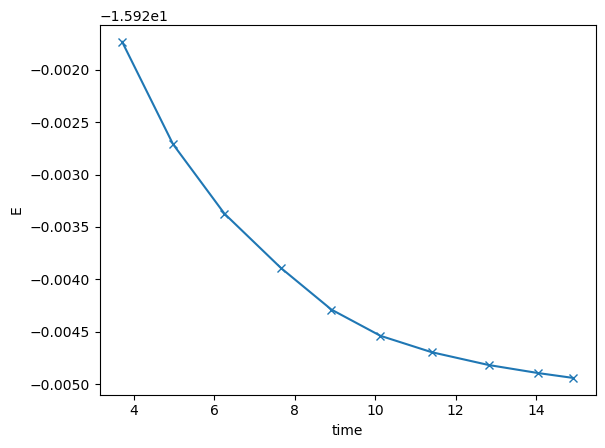

In [11]:
engine.plot_sweep_stats()

In [17]:
# Comparison with Martin's ed result

import sys, os
sys.path.append("common_lib/test/")
from test_qwz_spin_projected_energy import test_qwz_spin_projected_energy  
test_qwz_spin_projected_energy("square_8d0", t = t, m = m, U = U) 

Using square_8d0 with qwz
Evaluating the spectrum information for U = 1.0, t = 1.0, m = 1.0.
The low energy spectrum consists of energies: [-15.92535588 -15.14535794 -14.52283518 -14.52292879 -13.91636269]
